In [97]:
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import timeit
from PIL import Image, ImageOps
import cv2
from itertools import permutations
from skimage import io, color
from scipy.spatial import ConvexHull
import csv


In [98]:
class Node:
    generatedEquallySpacedNodes = []
    def __init__(self, coordinates, isTraversable = True, isEquallySpaced = True):
        self.coordinates = coordinates
        self.isTraversable = isTraversable
        self.isEquallySpaced = isEquallySpaced
        self.neighbours = {}


    def addNeighbour(self, neighbour, cost):
        if neighbour.isTraversable:
            self.neighbours[neighbour] = cost
            return True
        else:
            return False
        

    def deleteNeighbour(self, neighbour):
        try:
            self.neighbours.pop(neighbour)
            return True
        except:
            return False
        
    def addUserDefinedNeighbour(self, possibleNeighbourNodes, maximumAllowableNeighbouringCost):
        for possibleNeighbour in possibleNeighbourNodes:
            cost = ((possibleNeighbour.getCoordinates()[0]-self.coordinates[0])**2+(possibleNeighbour.getCoordinates()[1]-self.coordinates[1])**2)**0.5
            if cost <= maximumAllowableNeighbouringCost:
                self.addNeighbour(possibleNeighbour, cost)
                possibleNeighbour.addNeighbour(self, cost)
                
    def getCoordinates(self):
        return self.coordinates
    


def fromImageToBooleanGrid(processedImage, spacing, ObstacleThreshold = 10): #Equidistant Nodes Generating Function
    [imageWidth, imageHeight] = processedImage.size
    rows = math.floor(imageHeight / spacing)
    columns = math.floor(imageWidth / spacing)
    equallySpacedNodesMatrix = np.ones((rows, columns))
    rowCount = 0
    columnCount = 0
    for row in equallySpacedNodesMatrix:
        for node in row:
            if processedImage.getpixel((columnCount * spacing, rowCount * spacing)) < ObstacleThreshold:
                equallySpacedNodesMatrix[rowCount, columnCount] = 0
            columnCount += 1
        rowCount += 1
        columnCount = 0
    return equallySpacedNodesMatrix


def generateNodesFromMatrix(equallySpacedNodesMatrix, spacing): #This function transforms the generated boolean grid of equidistant nodes coordinates to a matrix of Node objects and defines their traversability
    rows = equallySpacedNodesMatrix.shape[0]
    columns = equallySpacedNodesMatrix.shape[1]
    rowCount = 0
    columnCount = 0
    nodes = np.empty((rows, columns), dtype = object)
    for row in equallySpacedNodesMatrix:
        for element in row:
            if element == 1: #greyImage.getpixel((columnCount * spacing, rowCount * spacing)) < 10:
                node = Node((columnCount * spacing, rowCount * spacing), True, True)
            else:
                node = Node((columnCount * spacing, rowCount * spacing), False, True)
            nodes[rowCount][columnCount] = node
            columnCount += 1
        rowCount += 1
        columnCount = 0

    return nodes






def getNodesCoordinatesFromNodesVector(nodesVetor):
    XTraversable = []
    YTraversable = []
    XObstacle = []
    YObstacle = []

    for node in nodesVetor:
        try:
            if node.isTraversable:
                XTraversable.append(node.getCoordinates()[0])
                YTraversable.append(node.getCoordinates()[1])
            else:
                XObstacle.append(node.getCoordinates()[0])
                YObstacle.append(node.getCoordinates()[1])
        except:
            pass
    return [[XTraversable, YTraversable], [XObstacle, YObstacle]]






def defineNeighbourhoodRelationsOfNodesMatrix(nodesMatrix, spacing):
    rowCount = 0
    columnCount = 0
    inputSpacing = spacing
    for row in nodesMatrix:
        for node in row:
            spacing = inputSpacing
            try:
                if not node.isTraversable:
                    spacing = float('inf')                          
                try:
                    node.addNeighbour(nodesMatrix[abs(rowCount-1)][abs(columnCount-1)], 2**0.5*spacing)
                except:

                    pass

                try:
                    node.addNeighbour(nodesMatrix[abs(rowCount - 1)][columnCount], spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[abs(rowCount-1)][columnCount+1], 2**0.5*spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount][abs(columnCount-1)], spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount][columnCount+1], spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount+1][abs(columnCount-1)], 2**0.5*spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount+1][columnCount], spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount+1][columnCount+1], 2**0.5*spacing)
                except:
                    pass

            except:
                pass
            columnCount += 1

        rowCount += 1
        columnCount = 0
    return nodesMatrix





def getTraversableAndObstacleNodes(allNodesVector): # This function returns a list of the travesable nodes (Node objects) and obstacle nodes (Node objects)
    traversableNodes = []
    obstacleNodes = []
    for node in allNodesVector:
        if node.isTraversable:
            traversableNodes.append(node)
        else:
            obstacleNodes.append(node)
        
    return [traversableNodes, obstacleNodes]






def generateUserDefinedNodes(greyImage, ObstacleThreshold,  nodesCoordinates, maximumAllowableNeighbouringCost, allNodesVector):
    
    generatedUserDefinedNodes = []
    for nodeCoordinate in nodesCoordinates:
        if greyImage.getpixel(nodeCoordinate) < ObstacleThreshold:
            isTraversable = False
        else:
            isTraversable = True
        tempNode = Node(nodeCoordinate, isTraversable, False)
        if tempNode not in allNodesVector[0] and tempNode not in allNodesVector[1]:
            if isTraversable:
                tempNode.addUserDefinedNeighbour(allNodesVector[0], maximumAllowableNeighbouringCost)
                allNodesVector[0].append(tempNode)
            else:
                tempNode.addUserDefinedNeighbour(allNodesVector[1], maximumAllowableNeighbouringCost)
                allNodesVector[1].append(tempNode)
        generatedUserDefinedNodes.append(tempNode)
    return generatedUserDefinedNodes
    
def getNodesCoordinatesTuplesFromNodesVector(nodesVetor):
    coordinates = []
    for node in nodesVetor:
        coordinates.append(node.coordinates)
    return coordinates


def calculateHeuristics(node, goalNode): #calculating the optimistic cost between nodes in a list and a desired node
    return  ((node.coordinates[0] - goalNode.coordinates[0]) ** 2 + (node.coordinates[1] - goalNode.coordinates[1]) ** 2) ** 0.5




def bresenham_line(x0, y0, x1, y1):
    """Bresenham's line algorithm to generate points on a line from (x0, y0) to (x1, y1)"""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points

def isLineObstacleFree(start, end, grayImage):
    line_points = bresenham_line(start.coordinates[0], start.coordinates[1], end.coordinates[0], end.coordinates[1])
    for x, y in line_points:
        if grayImage[y, x] <= 150:  # Check for black pixels
            return False
    return True

def postPrunePath(path, grayImage):
    
    startingNode = path[0]
    endNode = path[-1]
    prunedPath = [path[0]]  # Start with the first node

    i = 0
    while i < len(path) - 1:

        j = len(path) - 1
        while j > i:

            if isLineObstacleFree(path[i], path[j], grayImage):
                prunedPath.append(path[j])
                i = j
                break
            j -= 1
            if i == j:
                i += 1
                break
    if prunedPath[0] != startingNode:
        prunedPath.insert(0, startingNode)
    if prunedPath[-1] != endNode:
        prunedPath.append(endNode)

    return prunedPath






def AStarAlgorithm(startingNode, goalNode, generatedPaths, cv2GrayImage, isPostPruned = True, spacing = 40):
    previouslyFoundPathAndCost = generatedPaths.get((startingNode, goalNode), None)
    if previouslyFoundPathAndCost!= None and previouslyFoundPathAndCost[0][-1] != goalNode:
        previouslyFoundPathAndCost = None   
    if previouslyFoundPathAndCost != None:
        #print("Previously Generated Path Is Found!")
        return previouslyFoundPathAndCost
    
    openSet = [startingNode] # list to store the nodes to visit
    closedSet = [] # list to store the visited nodes
    g = {}  # list of cost from the starting node to the current node
    parents = {}  # the current parent of the node regarding the last update
    g[startingNode] = 0 # the cost of the starting node = 0
    parents[startingNode] = startingNode # the parent of the starting node is itself
    subPath = None
    while len(openSet) > 0:
        n = None # the node with the lowest f= g+h is found
        for temp in openSet:
            if n == None or g[temp] + calculateHeuristics(temp, goalNode) < g[n] + calculateHeuristics(n, goalNode):
                n = temp
                #should put a break in here to enhance the performance
        if n == goalNode or len(n.neighbours) == 0 :
            pass
        else:
            for (m, cost) in n.neighbours.items():
                if m not in openSet and m not in closedSet:
                    openSet.append(m)
                    parents[m] = n
                    g[m] = g[n] + cost
                else:
                    if g[m] > g[n] + cost:
                        g[m] = g[n] + cost
                        parents[m] = n
                        if m in closedSet:
                            closedSet.remove(m)
                            openSet.append(m)
        if n == None:
            print('>>>>Path does not exist!<<<<\n')
            return None
        
        if subPath != None:
            n = subPath[0][0]
            parents[goalNode] = n
            g[goalNode] = g[n] + subPath[1]

            n = goalNode

        if n == goalNode:
            path = []
            while parents[n] != n:
                path.append(n)
                n = parents[n]
            path.append(startingNode)
            totalCost = g[goalNode]
            pathCopy = path.copy()
            pathCopy.insert(0, goalNode)
            path.reverse()

            if isPostPruned:
                path = postPrunePath(path, cv2GrayImage)
                pathCopy = path.copy()

            generatedPaths[(goalNode, startingNode)] = [pathCopy, totalCost]
            generatedPaths[(startingNode, goalNode)] = [path, totalCost]
            
            pathAndTotalCost = [path, totalCost]
            return pathAndTotalCost

        openSet.remove(n)
        closedSet.append(n)


        '''rho = ((goalNode.coordinates[0] - n.coordinates[0]) ** 2 + (goalNode.coordinates[1] - n.coordinates[1]) ** 2) ** 0.5
        if isLineObstacleFree(n, goalNode, cv2GrayImage):
            subPath = [[n, goalNode], rho]'''


    print('>>>>Path does not exist!<<<<\n')
    return None



def calculatePathCost(path):
    cost = 0
    i = 0
    while i < len(path) - 1:
        distance = ((path[i + 1].coordinates[0] - path[i].coordinates[0])**2 + (path[i + 1].coordinates[1] - path[i].coordinates[1])**2)**0.5
        cost += distance
        i += 1
    
    return cost




def getGoalNodesCentroidCoordinates(goalNodes):
    centroidX = 0
    centroidY = 0

    for node in goalNodes:
        try:
            centroidX += node.getCoordinates()[0]
            centroidY += node.getCoordinates()[1]
        except:
            pass
    centroidX /= len(goalNodes)
    centroidY /= len(goalNodes)
    return (int(centroidX), int(centroidY))



def getAngleAlpha(centroidNodeCoordinates, currentNodeCoordinates, goalNodeCoordinates):
    centroidCurrentVector = np.array([currentNodeCoordinates[0] - centroidNodeCoordinates[0], currentNodeCoordinates[1] - centroidNodeCoordinates[1]])

    xGoal, yGoal = goalNodeCoordinates
    centroidGoalVector = np.array([xGoal - centroidNodeCoordinates[0], yGoal - centroidNodeCoordinates[1]])

    angleRad = np.arccos(np.dot(centroidCurrentVector, centroidGoalVector)/(np.linalg.norm(centroidCurrentVector)*np.linalg.norm(centroidGoalVector)))
    betaD = np.degrees(angleRad)

    return betaD



def getAngleBeta(startingNodeCoordinates, currentNodeCoordinates, goalNodeCoordinates):

    startingCurrentVector = np.array([currentNodeCoordinates[0] - startingNodeCoordinates[0], currentNodeCoordinates[1] - startingNodeCoordinates[1]])

    xGoal, yGoal = goalNodeCoordinates
    startGoalVector = np.array([xGoal - startingNodeCoordinates[0], yGoal - startingNodeCoordinates[1]])

    angleRad = np.arccos(np.dot(startingCurrentVector, startGoalVector)/(np.linalg.norm(startingCurrentVector)*np.linalg.norm(startGoalVector)))
    gammaD = np.degrees(angleRad)

    return gammaD




def getAngleGamma(currentNodeCoordinates, nearGoalNodeCoordinates, temporaryGoalNodeCoordinates):

    xGoalNear, yGoalNear = nearGoalNodeCoordinates
    currentNearGoalVector = np.array([xGoalNear - currentNodeCoordinates[0], yGoalNear - currentNodeCoordinates[1]])
    xGoalTemp, yGoalTemp = temporaryGoalNodeCoordinates
    currentTempGoalVector = np.array([xGoalTemp - currentNodeCoordinates[0], yGoalTemp - currentNodeCoordinates[1]])

    angleRad = np.arccos(np.dot(currentNearGoalVector, currentTempGoalVector)/(np.linalg.norm(currentNearGoalVector)*np.linalg.norm(currentTempGoalVector)))
    zetaD = np.degrees(angleRad)

    return zetaD



def generateTotalPath(startingNode, orderedGoalNodes, generatedPaths, cv2GrayImage):

    totalPath = []
    costs = []
    totalCost = 0

    startingNodeHolder = startingNode
    for node in orderedGoalNodes[1:-1]:

        AstarAlgoOutput = AStarAlgorithm(startingNodeHolder, node, generatedPaths, cv2GrayImage)
        startingNodeHolder = node
        totalPath = totalPath + AstarAlgoOutput[0]
        costs.append(AstarAlgoOutput[1])
        totalCost = totalCost + AstarAlgoOutput[1]
    AstarAlgoOutput = AStarAlgorithm(startingNodeHolder, startingNode, generatedPaths, cv2GrayImage)
    totalPath = totalPath + AstarAlgoOutput[0]
    costs.append(AstarAlgoOutput[1])
    totalCost = totalCost + AstarAlgoOutput[1]

    totalPathAndCost = [totalPath, totalCost]
    return totalPathAndCost

def removeConsecutiveDuplicateNodes(path):

    result = []
    

    for i in range(len(path)):

        if i == len(path) - 1 or path[i].coordinates != path[i + 1].coordinates:
            result.append(path[i])
    result.append(path[0])
    return result


def getCombinedAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, centroidNodeCoordinates, cv2GrayImage, closedPath = True):
    startingNodeHolder = absoluteStartingNode
    goalNodesHolder = goalNodes.copy()
    orderedGoalNodesOutput = []

    while len(goalNodesHolder)>0:
        orderedGoalNodes = []
        # Euclidean-Based Heuristic Ordering
        for node in goalNodesHolder:
            orderedGoalNodes.append([node, math.sqrt((startingNodeHolder.coordinates[0] - node.coordinates[0]) ** 2 + (startingNodeHolder.coordinates[1] - node.coordinates[1]) ** 2)])
        orderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
        # A*-Based Ordering
        if len(orderedGoalNodes)>=3:
            counter = 3
            while counter > 0:
                for node in orderedGoalNodes:
                    orderedGoalNodes[orderedGoalNodes.index(node)][1] = \
                    AStarAlgorithm(startingNodeHolder, node[0], generatedPaths, cv2GrayImage)[1]
                    counter -= 1
                    if counter == 0:
                        orderedOrderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
                        if orderedGoalNodes == orderedOrderedGoalNodes:
                            break
                        else:
                            orderedGoalNodes = orderedOrderedGoalNodes
                            counter = 1

        holder = orderedGoalNodes[0][0]

        if len(orderedGoalNodes) > 2:
            alpha1 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            alpha2 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            gamma1 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates, orderedGoalNodes[2][0].coordinates)
            gamma2 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates, orderedGoalNodes[2][0].coordinates)

            if alpha1 + gamma2 > alpha2 + gamma1 and alpha1 > alpha2:
                holder = orderedGoalNodes[1][0]

        elif len(orderedGoalNodes) < 3 and closedPath:
            costToAbsoluteStartingNode = AStarAlgorithm(startingNodeHolder, absoluteStartingNode, generatedPaths, cv2GrayImage)[1]
            orderedGoalNodes.append([absoluteStartingNode, costToAbsoluteStartingNode])

            alpha1 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            alpha2 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            gamma1 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates, orderedGoalNodes[2][0].coordinates)
            gamma2 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates, orderedGoalNodes[2][0].coordinates)

            if alpha1 + gamma2 > alpha2 + gamma1 and alpha1 > alpha2:
                holder = orderedGoalNodes[1][0]
                orderedGoalNodesOutput.append(orderedGoalNodes[1][0])
                orderedGoalNodesOutput.append(orderedGoalNodes[0][0])
            else:
                orderedGoalNodesOutput.append(orderedGoalNodes[0][0])
                orderedGoalNodesOutput.append(orderedGoalNodes[1][0])

            goalNodesHolder.remove(orderedGoalNodes[0][0])
            goalNodesHolder.remove(orderedGoalNodes[1][0])
            if closedPath:
                orderedGoalNodesOutput.insert(0, absoluteStartingNode)
                orderedGoalNodesOutput.append(absoluteStartingNode)
            return orderedGoalNodesOutput

        orderedGoalNodesOutput.append(holder)
        startingNodeHolder = holder
        goalNodesHolder.remove(holder)

    if closedPath:
        orderedGoalNodesOutput.append(absoluteStartingNode)
    return orderedGoalNodesOutput




def getSequentialAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, centroidNodeCoordinates, cv2GrayImage, closedPath = True):
    startingNodeHolder = absoluteStartingNode
    goalNodesHolder = goalNodes.copy()
    orderedGoalNodesOutput = []

    while len(goalNodesHolder)>0:
        orderedGoalNodes = []
        # Euclidean-Based Heuristic Ordering
        for node in goalNodesHolder:
            orderedGoalNodes.append([node, math.sqrt((startingNodeHolder.coordinates[0] - node.coordinates[0]) ** 2 + (startingNodeHolder.coordinates[1] - node.coordinates[1]) ** 2)])
        orderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
        # A*-Based Ordering
        if len(orderedGoalNodes)>=3:
            counter = 3
            while counter > 0:
                for node in orderedGoalNodes:
                    orderedGoalNodes[orderedGoalNodes.index(node)][1] = \
                    AStarAlgorithm(startingNodeHolder, node[0], generatedPaths, cv2GrayImage)[1]
                    counter -= 1
                    if counter == 0:
                        orderedOrderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
                        if orderedGoalNodes == orderedOrderedGoalNodes:
                            break
                        else:
                            orderedGoalNodes = orderedOrderedGoalNodes
                            counter = 1

        holder = orderedGoalNodes[0][0]

        if len(orderedGoalNodes) > 2:
            alpha1 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            alpha2 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            beta1 = getAngleBeta(absoluteStartingNode.coordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            beta2 = getAngleBeta(absoluteStartingNode.coordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            gamma1 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates, orderedGoalNodes[2][0].coordinates)
            gamma2 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates, orderedGoalNodes[2][0].coordinates)

            if alpha1 > alpha2 and gamma1 < gamma2 and beta1 > beta2:
                holder = orderedGoalNodes[1][0]

        elif len(orderedGoalNodes) < 3 and closedPath:
            costToAbsoluteStartingNode = AStarAlgorithm(startingNodeHolder, absoluteStartingNode, generatedPaths, cv2GrayImage)[1]
            orderedGoalNodes.append([absoluteStartingNode, costToAbsoluteStartingNode])

            alpha1 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            alpha2 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            beta1 = getAngleBeta(absoluteStartingNode.coordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            beta2 = getAngleBeta(absoluteStartingNode.coordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            if alpha1 > alpha2 and beta1 > beta2: #and zeta1 < zeta2:
                holder = orderedGoalNodes[1][0]
                orderedGoalNodesOutput.append(orderedGoalNodes[1][0])
                orderedGoalNodesOutput.append(orderedGoalNodes[0][0])
            else:
                orderedGoalNodesOutput.append(orderedGoalNodes[0][0])
                orderedGoalNodesOutput.append(orderedGoalNodes[1][0])
            if closedPath:
                orderedGoalNodesOutput.insert(0, absoluteStartingNode)
                orderedGoalNodesOutput.append(absoluteStartingNode)
            return orderedGoalNodesOutput

        orderedGoalNodesOutput.append(holder)
        startingNodeHolder = holder
        goalNodesHolder.remove(holder)

    if closedPath:
        orderedGoalNodesOutput.append(absoluteStartingNode)
    return orderedGoalNodesOutput

    
def getAngleBasedEnsembleOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, centroidNodeCoordinates, cv2GrayImage, closedPath = True):




    combinedAngleBasedOrderedGoalNodesStartTime = time.time()
    combinedAngleBasedOrderedGoalNodes = getCombinedAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    totalPathAndCostCombined = generateTotalPath(absoluteStartingNode, combinedAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
    combinedAngleBasedOrderedGoalNodesEndTime = time.time()
    combinedAngleBasedOrderedGoalNodesExecutionTime = combinedAngleBasedOrderedGoalNodesEndTime - combinedAngleBasedOrderedGoalNodesStartTime


    


    sequentialAngleBasedOrderedGoalNodesStartTime = time.time()
    sequentialAngleBasedOrderedGoalNodes = getSequentialAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    totalPathAndCostSequential = generateTotalPath(absoluteStartingNode, sequentialAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
    sequentialAngleBasedOrderedGoalNodesEndTime = time.time()
    sequentialAngleBasedOrderedGoalNodesExecutionTime = sequentialAngleBasedOrderedGoalNodesEndTime - sequentialAngleBasedOrderedGoalNodesStartTime   




    outputs = [(combinedAngleBasedOrderedGoalNodes, totalPathAndCostCombined[0], totalPathAndCostCombined[1], combinedAngleBasedOrderedGoalNodesExecutionTime, 'Combined'),
                (sequentialAngleBasedOrderedGoalNodes, totalPathAndCostSequential[0], totalPathAndCostSequential[1], sequentialAngleBasedOrderedGoalNodesExecutionTime, 'Sequential')]
    
    orderedOutputs = sorted(outputs, key = lambda x: x[2])
    return orderedOutputs

def getNearestOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, cv2GrayImage, closedPath = True): #This function resort the goalNodes list so that the optimal order to visit the goal nodes is obtained
    startingNodeHolder = absoluteStartingNode
    goalNodesHolder = goalNodes
    orderedGoalNodesOutput = []

    while len(goalNodesHolder)>0:
        orderedGoalNodes = []
        #Euclidean-Based Heuristic Ordering
        for node in goalNodesHolder:
            orderedGoalNodes.append([node, math.sqrt((startingNodeHolder.coordinates[0] - node.coordinates[0]) ** 2 + (startingNodeHolder.coordinates[1] - node.coordinates[1]) ** 2)])
            orderedGoalNodes.append([node, AStarAlgorithm(startingNodeHolder, node, generatedPaths, cv2GrayImage)[1]])
        orderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
        
        holder = orderedGoalNodes[0][0]
        orderedGoalNodesOutput.append(holder)
        startingNodeHolder = holder
        goalNodesHolder.remove(holder)
    if closedPath:
        orderedGoalNodesOutput.insert(0, absoluteStartingNode)
        orderedGoalNodesOutput.append(absoluteStartingNode)
    return orderedGoalNodesOutput


def getMuGONAOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, cv2GrayImage, closedPath = True, nonZiczac = True): 
    startingNodeHolder = absoluteStartingNode
    goalNodesHolder = goalNodes
    orderedGoalNodesOutput = []

    while len(goalNodesHolder)>0:
        orderedGoalNodes = []
        #Euclidean-Based Heuristic Ordering
        for node in goalNodesHolder:
            orderedGoalNodes.append([node, math.sqrt((startingNodeHolder.coordinates[0] - node.coordinates[0]) ** 2 + (startingNodeHolder.coordinates[1] - node.coordinates[1]) ** 2)])
        orderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
        #A*-Based Ordering
        if len(orderedGoalNodes)>=3:
            counter = 3
            while counter > 0:
                for node in orderedGoalNodes:
                    orderedGoalNodes[orderedGoalNodes.index(node)][1] = \
                    AStarAlgorithm(startingNodeHolder, node[0], generatedPaths, cv2GrayImage)[1]
                    counter -= 1
                    if counter == 0:
                        orderedOrderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
                        if orderedGoalNodes == orderedOrderedGoalNodes:
                            break

                        else:
                            orderedGoalNodes = orderedOrderedGoalNodes
                            counter = 1# I have to check if putting 1 instead of 3 does not affect the algorithm badly

        holder = orderedGoalNodes[0][0]
        if len(orderedGoalNodes) < 3 and closedPath:
            costToAbsoluteStartingNode = AStarAlgorithm(node, absoluteStartingNode, generatedPaths, cv2GrayImage)
            orderedGoalNodes.append([absoluteStartingNode, costToAbsoluteStartingNode])

        if not nonZiczac:
            if len(orderedGoalNodes) > 1 and startingNodeHolder != absoluteStartingNode:  # for ziczac paths
                costToAbsoluteStartingNode1 = \
                AStarAlgorithm(orderedGoalNodes[0][0], absoluteStartingNode, generatedPaths, cv2GrayImage)[1]
                costToAbsoluteStartingNode2 = \
                AStarAlgorithm(orderedGoalNodes[1][0], absoluteStartingNode, generatedPaths, cv2GrayImage)[1]
                if (costToAbsoluteStartingNode1 < costToAbsoluteStartingNode2):
                    holder = orderedGoalNodes[1][0]
        else:
            if len(orderedGoalNodes) > 2:
                costBetweenNode1AndTemporaryGoalNode = \
                    AStarAlgorithm(orderedGoalNodes[0][0], orderedGoalNodes[2][0], generatedPaths, cv2GrayImage)[1]
                costBetweenNode2AndTemporaryGoalNode = \
                    AStarAlgorithm(orderedGoalNodes[1][0], orderedGoalNodes[2][0], generatedPaths, cv2GrayImage)[1]
                costBetweenNode1AndNode2 = \
                    AStarAlgorithm(orderedGoalNodes[0][0], orderedGoalNodes[1][0], generatedPaths, cv2GrayImage)[1]
                if orderedGoalNodes[0][1] + costBetweenNode1AndNode2 + costBetweenNode2AndTemporaryGoalNode > \
                        orderedGoalNodes[1][1] + costBetweenNode1AndNode2 + costBetweenNode1AndTemporaryGoalNode:  #I figured out that the common term in both expression can be cancelled from both sides of the inequality
                    holder = orderedGoalNodes[1][0]

        orderedGoalNodesOutput.append(holder)
        startingNodeHolder = holder
        goalNodesHolder.remove(holder)
        #print(f"orderedGoalNodesOutput: {orderedGoalNodesOutput}\n")
    if closedPath:
        orderedGoalNodesOutput.append(absoluteStartingNode)
        orderedGoalNodesOutput.insert(0, absoluteStartingNode)
    #print("The MuGONA-Based ordering Process is FINISHED!!\n")
    return orderedGoalNodesOutput


def getNodesInFourQuadrants(CentroidNodeCoordinates, goalNodes):
    nodesInQuadrant1 = []
    nodesInQuadrant2 = []
    nodesInQuadrant3 = []
    nodesInQuadrant4 = []
    for node in goalNodes:
        deltaX = node.coordinates[0]-CentroidNodeCoordinates[0]
        deltaY = node.coordinates[1]-CentroidNodeCoordinates[1]
        if deltaX >=0 and deltaY >= 0:
            nodesInQuadrant1.append(node)
        elif deltaX < 0 and deltaY >=0:
            nodesInQuadrant2.append(node)
        elif deltaX < 0 and deltaY < 0:
            nodesInQuadrant3.append(node)
        elif deltaX >= 0 and deltaY < 0:
            nodesInQuadrant4.append(node)

    return [nodesInQuadrant1, nodesInQuadrant2, nodesInQuadrant3, nodesInQuadrant4] #Or we may return the label of the quarter with the minimum non-zero number of nodes

def getQuadrantLabel(CentroidNodeCoordinates, goalNode):
    deltaX = goalNode.coordinates[0]-CentroidNodeCoordinates[0]
    deltaY = goalNode.coordinates[1]-CentroidNodeCoordinates[1]
    if deltaX >=0 and deltaY >= 0:
        return 1
    elif deltaX < 0 and deltaY >=0:
        return 2
    elif deltaX < 0 and deltaY < 0:
        return 3
    elif deltaX >= 0 and deltaY < 0:
        return 4


def classifyGoalNodes(startingNode, centroidNodeCoordinates, goalNodes):
    lowerGoalNodes = []
    upperGoalNodes = []
    
    slope = (centroidNodeCoordinates[1] - startingNode.coordinates[1]) / (centroidNodeCoordinates[0] - startingNode.coordinates[0])
    y_intercept = startingNode.coordinates[1] - slope * startingNode.coordinates[0]
    
    for goalNode in goalNodes:
        yLine = slope * goalNode.coordinates[0] + y_intercept
        if goalNode.coordinates[1] <= yLine:
            lowerGoalNodes.append(goalNode)
        else:
            upperGoalNodes.append(goalNode)
    
    return lowerGoalNodes, upperGoalNodes


def getQuadrantBasedOrderedGoalNodes(startingNode, goalNodes, generatedPaths, centroidNodeCoordinates, cv2GrayImage):
    mapSize = (cv2GrayImage.shape[1], cv2GrayImage.shape[0])
    nodesInQuadrantsHolder = getNodesInFourQuadrants(centroidNodeCoordinates, goalNodes)
    startingNodeQuadrantLabel = getQuadrantLabel(centroidNodeCoordinates, startingNode)
    quadrant1BaseNoodeCoordinates = (mapSize[0], centroidNodeCoordinates[1])
    quadrant2BaseNoodeCoordinates = (centroidNodeCoordinates[0], mapSize[1])
    quadrant3BaseNoodeCoordinates = (0, centroidNodeCoordinates[1])
    quadrant4BaseNoodeCoordinates = (centroidNodeCoordinates[0], 0)
    orderedNodesInQuadrants = []
    if startingNodeQuadrantLabel == 2:
        nodesInQuadrants = [(nodesInQuadrantsHolder[1], 2, quadrant2BaseNoodeCoordinates), (nodesInQuadrantsHolder[2], 3, quadrant3BaseNoodeCoordinates), (nodesInQuadrantsHolder[3], 4, quadrant4BaseNoodeCoordinates), (nodesInQuadrantsHolder[0], 1, quadrant1BaseNoodeCoordinates)]
    elif startingNodeQuadrantLabel == 3:
        nodesInQuadrants = [(nodesInQuadrantsHolder[2], 3, quadrant3BaseNoodeCoordinates), (nodesInQuadrantsHolder[3], 4, quadrant4BaseNoodeCoordinates), (nodesInQuadrantsHolder[0], 1, quadrant1BaseNoodeCoordinates), (nodesInQuadrantsHolder[1], 2, quadrant2BaseNoodeCoordinates)]
    elif startingNodeQuadrantLabel == 4:
        nodesInQuadrants = [(nodesInQuadrantsHolder[3], 4, quadrant4BaseNoodeCoordinates), (nodesInQuadrantsHolder[0], 1, quadrant1BaseNoodeCoordinates), (nodesInQuadrantsHolder[1], 2, quadrant2BaseNoodeCoordinates), (nodesInQuadrantsHolder[2], 3, quadrant3BaseNoodeCoordinates)]
    else:
        nodesInQuadrants = [(nodesInQuadrantsHolder[0], 1, quadrant1BaseNoodeCoordinates), (nodesInQuadrantsHolder[1], 2, quadrant2BaseNoodeCoordinates), (nodesInQuadrantsHolder[2], 3, quadrant3BaseNoodeCoordinates), (nodesInQuadrantsHolder[3], 4, quadrant4BaseNoodeCoordinates)]

    lowerGoalNodes, upperGoalNodes = classifyGoalNodes(startingNode, centroidNodeCoordinates, nodesInQuadrants[0][0])
    if len(upperGoalNodes) > 0:
        isUpperFirst = True
    else:
        isUpperFirst = False
    orderedUpperGoalNodes = []
    orderedLowerGoalNodes = []

    orderedLowerGoalNodes = getSequentialAngleBasedOrderedGoalNodes(startingNode, lowerGoalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    orderedUpperGoalNodes = getSequentialAngleBasedOrderedGoalNodes(startingNode, upperGoalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    if nodesInQuadrants[0][1] == 1 and len(upperGoalNodes) > 0:
        isUpperFirst = True
    elif nodesInQuadrants[0][1] == 2 and len(lowerGoalNodes) > 0:
        isUpperFirst = False
    elif nodesInQuadrants[0][1] == 3 and len(lowerGoalNodes) > 0:
        isUpperFirst = False
    elif nodesInQuadrants[0][1] == 4 and len(upperGoalNodes) > 0:
        isUpperFirst = True

    def euclidean_distance(point1, point2):
        return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    def find_closest_point(coordinates_list, target_point):
        closest_point = None
        min_distance = float('inf')  # Initialize with a large value

        for point in coordinates_list:
            distance = euclidean_distance(point.coordinates, target_point)
            if distance < min_distance:
                min_distance = distance
                closest_point = point

        return closest_point, min_distance

    if isUpperFirst:
        firstOrderedNodes = orderedUpperGoalNodes.copy()
    else:
        firstOrderedNodes = orderedLowerGoalNodes.copy()

    baseNode1 = find_closest_point(nodesInQuadrants[1][0], firstOrderedNodes[-1].coordinates)[0]
    quadrantOrderedNodes2 = getSequentialAngleBasedOrderedGoalNodes(baseNode1, nodesInQuadrants[1][0].copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)

    baseNode2 = find_closest_point(nodesInQuadrants[2][0], quadrantOrderedNodes2[-1].coordinates)[0]
    quadrantOrderedNodes3 = getSequentialAngleBasedOrderedGoalNodes(baseNode2, nodesInQuadrants[2][0].copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    
    baseNode3 = find_closest_point(nodesInQuadrants[3][0], quadrantOrderedNodes3[-1].coordinates)[0]
    quadrantOrderedNodes4 = getSequentialAngleBasedOrderedGoalNodes(baseNode3, nodesInQuadrants[3][0].copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)

    if isUpperFirst:
        orderedLowerGoalNodes = getSequentialAngleBasedOrderedGoalNodes(quadrantOrderedNodes4[-1], lowerGoalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
        orderedNodesInQuadrants = orderedUpperGoalNodes + quadrantOrderedNodes2 + quadrantOrderedNodes3 + quadrantOrderedNodes4 + orderedLowerGoalNodes
    else:
        orderedUpperGoalNodes = getSequentialAngleBasedOrderedGoalNodes(quadrantOrderedNodes4[-1], upperGoalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
        orderedNodesInQuadrants = orderedLowerGoalNodes + quadrantOrderedNodes2 + quadrantOrderedNodes3 + quadrantOrderedNodes4 + orderedUpperGoalNodes

    orderedNodesInQuadrants.insert(0, startingNode)
    orderedNodesInQuadrants.append(startingNode)
    return orderedNodesInQuadrants



def ensembleOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, centroidNodeCoordinates, cv2GrayImage):

    MuGONAOrderedGoalNodesStartTime = time.time()
    MuGONAOrderedGoalNodes = getMuGONAOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, cv2GrayImage)
    totalPathAndCostMuGONA = generateTotalPath(absoluteStartingNode, MuGONAOrderedGoalNodes, generatedPaths, cv2GrayImage)
    MuGONAOrderedGoalNodesEndTime = time.time()
    MuGONAOrderedGoalNodesExecutionTime = MuGONAOrderedGoalNodesEndTime - MuGONAOrderedGoalNodesStartTime


    nearestNeighbourOrderedGoalNodesStartTime = time.time()
    nearestNeighbourOrderedGoalNodes = getNearestOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, cv2GrayImage)
    totalPathAndCostNearestNeighbour = generateTotalPath(absoluteStartingNode, nearestNeighbourOrderedGoalNodes, generatedPaths, cv2GrayImage)
    nearestNeighbourOrderedGoalNodesEndTime = time.time()
    nearestNeighbourOrderedGoalNodesExecutionTime = nearestNeighbourOrderedGoalNodesEndTime - nearestNeighbourOrderedGoalNodesStartTime


    combinedAngleBasedOrderedGoalNodesStartTime = time.time()
    combinedAngleBasedOrderedGoalNodes = getCombinedAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    totalPathAndCostCombined = generateTotalPath(absoluteStartingNode, combinedAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
    combinedAngleBasedOrderedGoalNodesEndTime = time.time()
    combinedAngleBasedOrderedGoalNodesExecutionTime = combinedAngleBasedOrderedGoalNodesEndTime - combinedAngleBasedOrderedGoalNodesStartTime


    


    sequentialAngleBasedOrderedGoalNodesStartTime = time.time()
    sequentialAngleBasedOrderedGoalNodes = getSequentialAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    totalPathAndCostSequential = generateTotalPath(absoluteStartingNode, sequentialAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
    sequentialAngleBasedOrderedGoalNodesEndTime = time.time()
    sequentialAngleBasedOrderedGoalNodesExecutionTime = sequentialAngleBasedOrderedGoalNodesEndTime - sequentialAngleBasedOrderedGoalNodesStartTime


    outputs = [(MuGONAOrderedGoalNodes, totalPathAndCostMuGONA[0], totalPathAndCostMuGONA[1], MuGONAOrderedGoalNodesExecutionTime, 'MuGONA'), (nearestNeighbourOrderedGoalNodes, totalPathAndCostNearestNeighbour[0], totalPathAndCostNearestNeighbour[1], nearestNeighbourOrderedGoalNodesExecutionTime, 'NN'), 
               (combinedAngleBasedOrderedGoalNodes, totalPathAndCostCombined[0], totalPathAndCostCombined[1], combinedAngleBasedOrderedGoalNodesExecutionTime, 'Combined'), (sequentialAngleBasedOrderedGoalNodes, totalPathAndCostSequential[0], totalPathAndCostSequential[1], sequentialAngleBasedOrderedGoalNodesExecutionTime, 'Sequential')]




    orderedOutputs = sorted(outputs, key = lambda x: x[2])
    
    return orderedOutputs


def getBestAStarBasedOrder(startingNode, goalNodes, generatedPaths, cv2GrayImage):
    cost = -1
    optimalPath = None
    possibleOrders = list(permutations(goalNodes))
    for possibleOrder in possibleOrders:
        possibleOrder = list(possibleOrder)
        possibleOrder.insert(0, startingNode)
        possibleOrder.append(startingNode)
        generatedPath = generateTotalPath(startingNode, possibleOrder, generatedPaths, cv2GrayImage)
        if cost < 0 or generatedPath[1] < cost:
            cost = generatedPath[1]
            optimalPath = generatedPath[0]
            optimalOrder = possibleOrder
    return [optimalPath, cost, optimalOrder]






def calculate_path_length(nodes):
    total_distance = 0
    for i in range(len(nodes) - 1):
        total_distance += np.linalg.norm(np.array(nodes[i].coordinates) - np.array(nodes[i + 1].coordinates))
    total_distance += np.linalg.norm(np.array(nodes[-1].coordinates) - np.array(nodes[0].coordinates))  # Close the loop
    return total_distance


def modifiedTwoOptPostPruning(nodes, cv2GrayImage):
    best_order = nodes[:]
    improved = True
    
    while improved:
        improved = False
        for i in range(1, len(best_order) - 2):
            for j in range(i + 1, len(best_order)):
                if j - i == 1 :  # Consecutive nodes, skip
                    continue
                if i>0 and j< len(best_order) -1: 
                    if not isLineObstacleFree(best_order[i-1], best_order[j], cv2GrayImage) or not isLineObstacleFree(best_order[i], best_order[j+1], cv2GrayImage):
                        continue
                new_order = best_order[:]
                new_order[i:j] = reversed(best_order[i:j])
                
                if calculate_path_length(new_order) < calculate_path_length(best_order):
                    best_order = new_order
                    improved = True
         
    return best_order




def two_opt_algorithm_with_Astar(startingNode, nodes, generatedPaths, cv2GrayImage):
    best_order = nodes[:]
    improved = True
    
    while improved:
        improved = False
        for i in range(1, len(best_order) - 2):
            for j in range(i + 1, len(best_order)):
                if j - i == 1:  # Consecutive nodes, skip
                    continue
                new_order = best_order[:]
                new_order[i:j] = reversed(best_order[i:j])
                
                if generateTotalPath(startingNode, new_order, generatedPaths, cv2GrayImage)[1] < generateTotalPath(startingNode, best_order, generatedPaths, cv2GrayImage)[1]:
                    best_order = new_order
                    improved = True
                    
    return best_order
    

#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
###################################################   MAIN   ####################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

## Uploading The Map and Setting User Choices ##

In [99]:

imageDirectory = 'map.png'
image = Image.open(imageDirectory)
greyImage = image.convert('L')
spacing =40#pixels
obstacleThreshold = 40 #less than 40 grey value--> obstacle
print(image.size)


(4800, 3840)


## Pre-Processing The Map ##

In [100]:
# Generating a boolean matrix that has the coordinates of the equally spaced nodes, If they are located on obstacels the value is 0 and 1 else where
equallySpacedNodesMatrix = fromImageToBooleanGrid(greyImage, spacing, obstacleThreshold)

# Transforming the boolean matrix of a matrix with Node() objects having their coordinates and traversability defined.
nodesMatrix = generateNodesFromMatrix(equallySpacedNodesMatrix, spacing)

# Obtaining the coordinates of both traversable and obstacle nodes in lists form to be plotted
nodesCoordinates = getNodesCoordinatesFromNodesVector(nodesMatrix.flatten())

XTraversable, YTraversable = nodesCoordinates[0][0], nodesCoordinates[0][1]
XObstacle, YObstacle = nodesCoordinates[1][0], nodesCoordinates[1][1]

defineNeighbourhoodRelationsOfNodesMatrix(nodesMatrix, spacing)

generatedPaths = {}
allNodesVector = getTraversableAndObstacleNodes(nodesMatrix.flatten())
userDefinedNodesCoordinates = [(300, 300), (400, 1255), (4314, 154), (646, 3678), (2100, 2325), (2710, 106), (1266, 164), (4000, 3660), (2800, 1775), (2475, 3277), (4200, 1500)]# list of goal nodes to visit
maximumAllowableNeighbouringCost = (2*spacing**2)**0.5
userDefinedNodes = generateUserDefinedNodes(greyImage, obstacleThreshold, userDefinedNodesCoordinates, maximumAllowableNeighbouringCost, allNodesVector)

print(len(allNodesVector[0]))

7848


`Equidistant Nodes Generation`

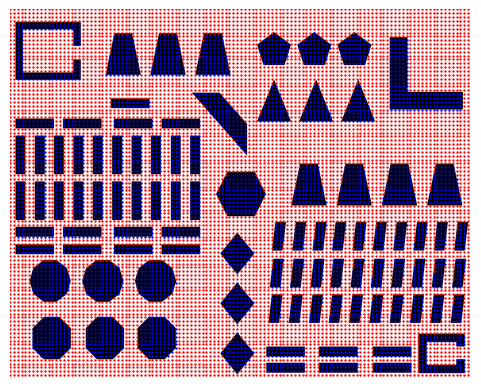

In [101]:

plt.scatter(XTraversable, YTraversable, c ='r', s=0.5)
plt.scatter(XObstacle, YObstacle, c ='b', s=0.5) 
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(image)
plt.axis('off')
plt.show()

``Non-Navigable Nodes``

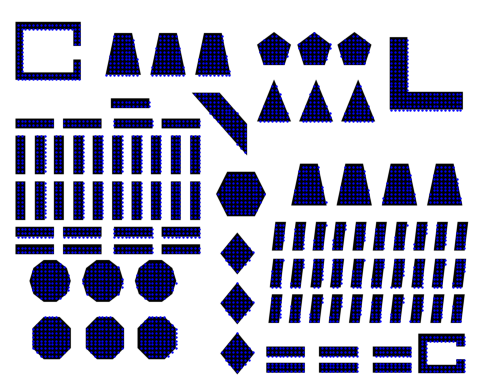

In [102]:

plt.scatter(XObstacle, YObstacle, c ='b', s=0.5) 
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(image)
plt.axis('off')
plt.show()

`Obstacle Contour Detection`

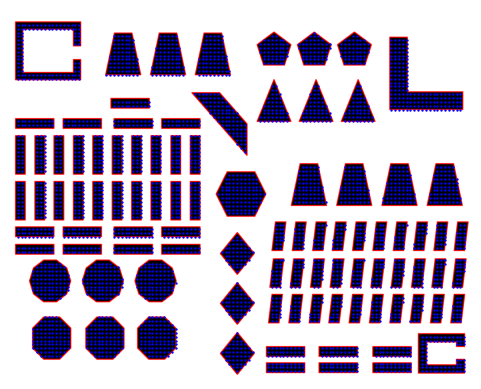

In [103]:

cv2GrayImage = cv2.imread(imageDirectory, cv2.IMREAD_GRAYSCALE)
obstacleThreshold = 128 
_, cv2BinaryImage = cv2.threshold(cv2GrayImage, obstacleThreshold, 255, cv2.THRESH_BINARY)
invertedGrayImage = cv2.bitwise_not(cv2GrayImage)
_, invertedBinaryImage = cv2.threshold(invertedGrayImage, 128, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(invertedBinaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

imageBGR = cv2.cvtColor(cv2GrayImage, cv2.COLOR_GRAY2BGR)

cv2.drawContours(imageBGR, contours, -1, (0, 0, 255), 10)  
plt.scatter(XObstacle, YObstacle, c ='b', s=0.5) 
plt.imshow(cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.show()

`Neighbourhood Graph: Equidistant Vs User-Defined`

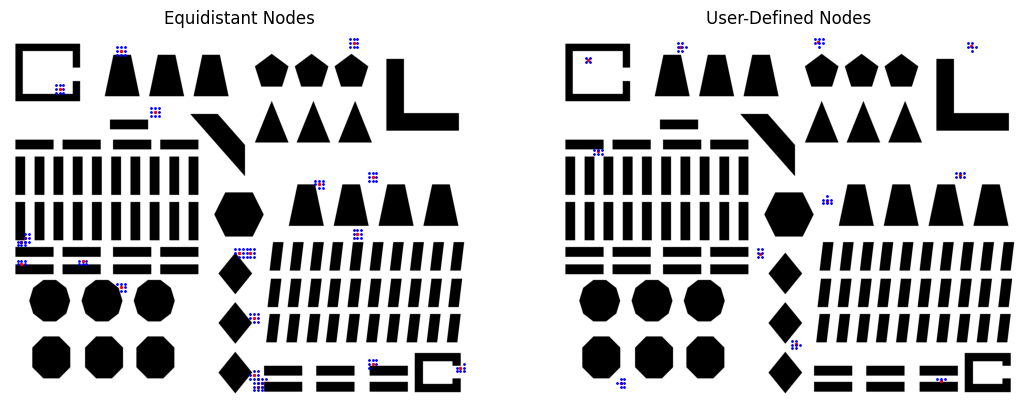

In [104]:

randomNodes = list(np.random.choice(allNodesVector[0], 20))

randomNodesNeighbours = []

for randomNode in randomNodes:
    randomNodesNeighbours = randomNodesNeighbours + list(randomNode.neighbours.keys())

XNodes = []
YNodes = []
for node in randomNodes:
    XNodes.append(node.coordinates[0])
    YNodes.append(node.coordinates[1])

XNeighbours = []
YNeighbours = []
for neighbour in randomNodesNeighbours:
    XNeighbours.append(neighbour.coordinates[0])
    YNeighbours.append(neighbour.coordinates[1])





userDefinedRandomNodes = userDefinedNodes.copy()
randomNodesNeighbours = []

for randomNode in userDefinedRandomNodes:
    randomNodesNeighbours = randomNodesNeighbours + list(randomNode.neighbours.keys())

XuserDefinedRandomNodesNodes = []
YuserDefinedRandomNodesNodes = []
for node in userDefinedRandomNodes:
    XuserDefinedRandomNodesNodes.append(node.coordinates[0])
    YuserDefinedRandomNodesNodes.append(node.coordinates[1])

XuserDefinedRandomNodesNeighbours = []
YuserDefinedRandomNodesNeighbours = []
for neighbour in randomNodesNeighbours:
    XuserDefinedRandomNodesNeighbours.append(neighbour.coordinates[0])
    YuserDefinedRandomNodesNeighbours.append(neighbour.coordinates[1])


plt.figure(figsize=(13, 11))
plt.subplot(1, 2, 1)
plt.scatter(XNodes, YNodes, c ='r', s=2)
plt.scatter(XNeighbours, YNeighbours, c ='b', s=1)
plt.title("Equidistant Nodes")
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(image)
plt.axis('off')


plt.subplot(1, 2, 2)
plt.scatter(XuserDefinedRandomNodesNodes, YuserDefinedRandomNodesNodes, c ='r', s=2)
plt.scatter(XuserDefinedRandomNodesNeighbours, YuserDefinedRandomNodesNeighbours, c ='b', s=1) 
plt.title("User-Defined Nodes")
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(image)
plt.axis('off')
plt.show()


# Improved A* Algorithm #

`Non Post-Pruned Path vs Post-Pruned Path`

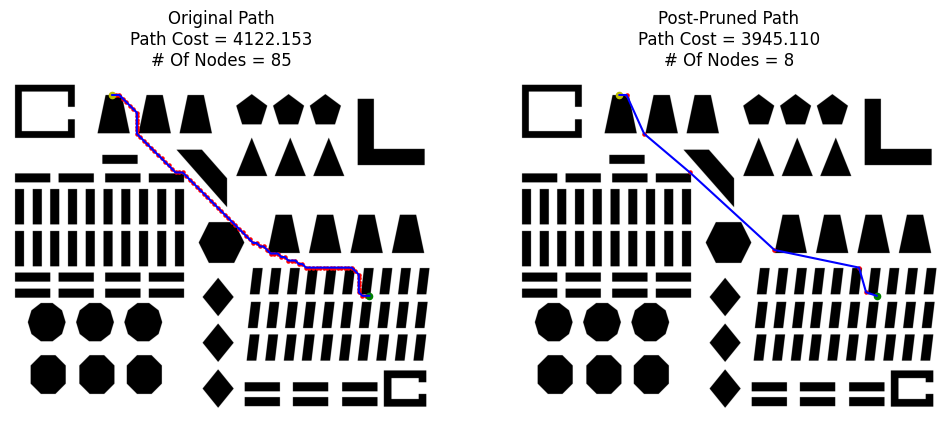

In [109]:
generatedPaths = {}

startingNode = list(np.random.choice(allNodesVector[0], 2))[0]
goalNode = list(np.random.choice(allNodesVector[0], 2))[0]


path = AStarAlgorithm(startingNode, goalNode, generatedPaths, cv2GrayImage, False, spacing)[0]
pathCost = calculatePathCost(path)
[[X, Y],_] = getNodesCoordinatesFromNodesVector(path)


prunedPath = postPrunePath(path.copy(), cv2GrayImage)
prunedPathCost = calculatePathCost(prunedPath)
[[XPruned, YPruned],_] = getNodesCoordinatesFromNodesVector(path)

plt.figure(figsize=(12,10))

plt.subplot(1, 2, 1)
plt.plot(XPruned, YPruned, c ='b')  
plt.scatter(XPruned, YPruned, c ='r', s=5) 
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=20)  
plt.scatter(goalNode.coordinates[0], goalNode.coordinates[1], c ='g', s=20)  
plt.title("Original Path\nPath Cost = {:.3f}\n# Of Nodes = {}".format(pathCost, len(path)))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout

[[XPruned, YPruned],_] = getNodesCoordinatesFromNodesVector(prunedPath)

plt.subplot(1, 2, 2)
plt.plot(XPruned, YPruned, c ='b') 
plt.scatter(XPruned, YPruned, c ='r', s=5)  
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=20) 
plt.scatter(goalNode.coordinates[0], goalNode.coordinates[1], c ='g', s=20)  
plt.title("Post-Pruned Path\nPath Cost = {:.3f}\n# Of Nodes = {}".format(prunedPathCost, len(prunedPath)))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout
plt.show()



## Ordering Module ##

In [110]:
startingNode = list(np.random.choice(allNodesVector[0], 2))[0]
absoluteStartingNode = startingNode
goalNodes = list(np.random.choice(allNodesVector[0], 15))
goalNodesAndStartingNode = goalNodes.copy()
goalNodesAndStartingNode.append(startingNode)
goalNodesAndStartingNodeCentroidCoordinates = getGoalNodesCentroidCoordinates(goalNodesAndStartingNode)
[[XGoal, YGoal],_] = getNodesCoordinatesFromNodesVector(goalNodes)


print("The starting node coordinates are: ", startingNode.coordinates)
print("The coordinates of the goal nodes are:")
for node in goalNodes:
    print(node.coordinates)

The starting node coordinates are:  (3320, 120)
The coordinates of the goal nodes are:
(200, 3720)
(3360, 1120)
(1800, 960)
(2560, 1240)
(4760, 1240)
(3760, 1880)
(560, 3800)
(4760, 3240)
(920, 960)
(2760, 1520)
(4040, 40)
(2560, 1440)
(3320, 1200)
(2680, 760)
(4400, 400)


`Sequential Angle-Based Vs. Combined Angle-Based Ordering`

Combined time taken for getCombinedAngleBasedOrderedGoalNodes and generateTotalPath: 3.9291422367095947 seconds
Combined time taken for getSequentialAngleBasedOrderedGoalNodes and generateTotalPath: 3.9291422367095947 seconds


C:\Users\abdul\AppData\Local\Temp\ipykernel_32116\469916358.py:397: RuntimeWarning: invalid value encountered in scalar divide
  angleRad = np.arccos(np.dot(startingCurrentVector, startGoalVector)/(np.linalg.norm(startingCurrentVector)*np.linalg.norm(startGoalVector)))


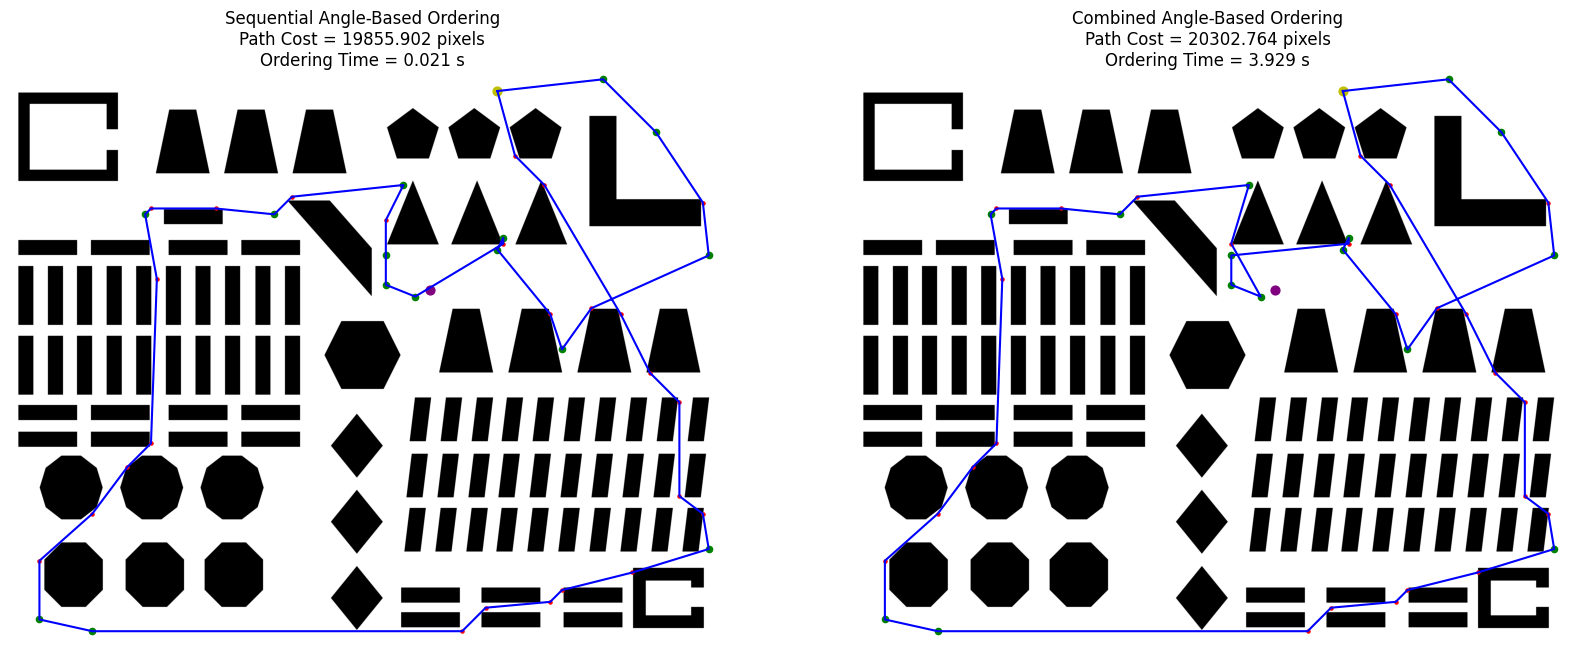

In [111]:


combinedAngleBasedOrderedGoalNodesStartTime = time.time()
combinedAngleBasedOrderedGoalNodes = getCombinedAngleBasedOrderedGoalNodes(startingNode, goalNodes.copy(), generatedPaths, goalNodesAndStartingNodeCentroidCoordinates, cv2GrayImage, True)
totalPathAndCostOfCombinedAngleBasedOrderedGoalNodes = generateTotalPath(startingNode, combinedAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
combinedAngleBasedOrderedGoalNodesEndTime = time.time()
combinedAngleBasedOrderedGoalNodesExecutionTime = combinedAngleBasedOrderedGoalNodesEndTime - combinedAngleBasedOrderedGoalNodesStartTime
print(f"Combined time taken for getCombinedAngleBasedOrderedGoalNodes and generateTotalPath: {combinedAngleBasedOrderedGoalNodesExecutionTime} seconds")


sequentialAngleBasedOrderedGoalNodesStartTime = time.time()
sequentialAngleBasedOrderedGoalNodes = getSequentialAngleBasedOrderedGoalNodes(startingNode, goalNodes.copy(), generatedPaths, goalNodesAndStartingNodeCentroidCoordinates, cv2GrayImage, True)
totalPathAndCostOfSequentialAngleBasedOrderedGoalNodes = generateTotalPath(startingNode, sequentialAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
sequentialAngleBasedOrderedGoalNodesEndTime = time.time()
sequentialAngleBasedOrderedGoalNodesExecutionTime = sequentialAngleBasedOrderedGoalNodesEndTime - sequentialAngleBasedOrderedGoalNodesStartTime
print(f"Combined time taken for getSequentialAngleBasedOrderedGoalNodes and generateTotalPath: {combinedAngleBasedOrderedGoalNodesExecutionTime} seconds")


[[XcombinedAngleBasedOrderedGoalNodes, YcombinedAngleBasedOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostOfCombinedAngleBasedOrderedGoalNodes[0])
[[XsequentialAngleBasedOrderedGoalNodes, YsequentialAngleBasedOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostOfSequentialAngleBasedOrderedGoalNodes[0])


plt.figure(figsize=(20,15))

plt.subplot(1, 2, 1)
plt.plot(XsequentialAngleBasedOrderedGoalNodes, YsequentialAngleBasedOrderedGoalNodes, c ='b')
plt.scatter(XsequentialAngleBasedOrderedGoalNodes, YsequentialAngleBasedOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Sequential Angle-Based Ordering\nPath Cost = {:.3f} pixels\nOrdering Time = {:.3f} s".format(totalPathAndCostOfSequentialAngleBasedOrderedGoalNodes[1], sequentialAngleBasedOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout



plt.subplot(1, 2, 2)
plt.plot(XcombinedAngleBasedOrderedGoalNodes, YcombinedAngleBasedOrderedGoalNodes, c ='b')
plt.scatter(XcombinedAngleBasedOrderedGoalNodes, YcombinedAngleBasedOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Combined Angle-Based Ordering\nPath Cost = {:.3f} pixels\nOrdering Time = {:.3f} s".format(totalPathAndCostOfCombinedAngleBasedOrderedGoalNodes[1], combinedAngleBasedOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout

plt.show()


`Post-Pruned Ensemble Angle-Based Ordering`

C:\Users\abdul\AppData\Local\Temp\ipykernel_32116\469916358.py:397: RuntimeWarning: invalid value encountered in scalar divide
  angleRad = np.arccos(np.dot(startingCurrentVector, startGoalVector)/(np.linalg.norm(startingCurrentVector)*np.linalg.norm(startGoalVector)))


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

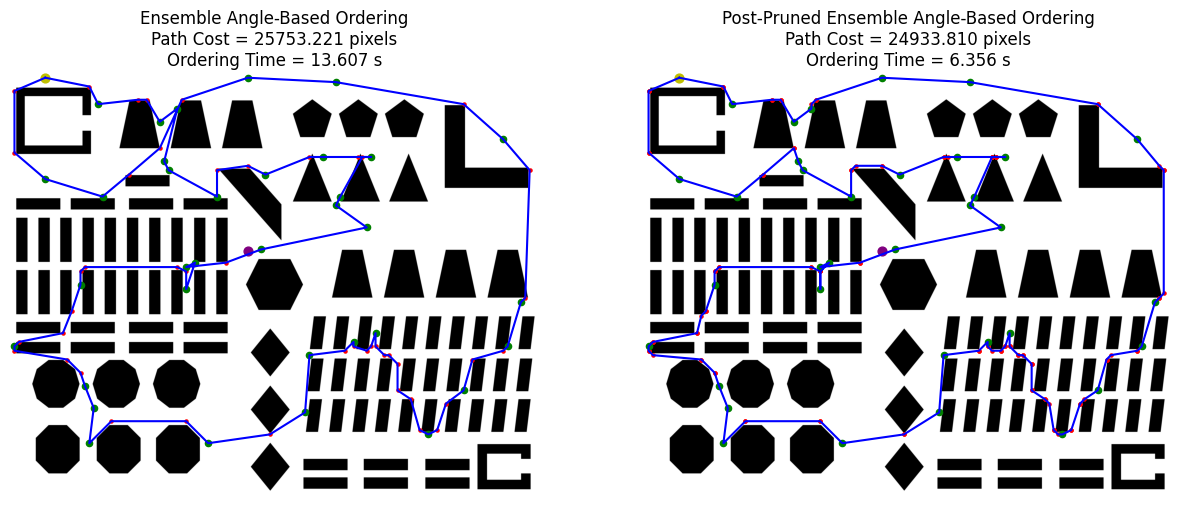

In [112]:
startingNode = list(np.random.choice(allNodesVector[0], 2))[0]
absoluteStartingNode = startingNode
goalNodes = list(np.random.choice(allNodesVector[0], 35))
goalNodesAndStartingNode = goalNodes.copy()
goalNodesAndStartingNode.append(startingNode)
goalNodesAndStartingNodeCentroidCoordinates = getGoalNodesCentroidCoordinates(goalNodesAndStartingNode)
[[XGoal, YGoal],_] = getNodesCoordinatesFromNodesVector(goalNodes)



ensembleAngleOrderedGoalNodesStartTime = time.time()
ensembleAngleOrderedGoalNodes = getAngleBasedEnsembleOrderedGoalNodes(startingNode, goalNodes.copy(), generatedPaths, goalNodesAndStartingNodeCentroidCoordinates, cv2GrayImage)[0]
totalPathAndCostOfensembleAngle = [ensembleAngleOrderedGoalNodes[1], ensembleAngleOrderedGoalNodes[2]]
ensembleAngleOrderedGoalNodesEndTime = time.time()
ensembleAngleOrderedGoalNodesExecutionTime = ensembleAngleOrderedGoalNodesEndTime - ensembleAngleOrderedGoalNodesStartTime




postPrunedOrderedGoalNodesStartTime = time.time()
#postPrunedOrderedGoalNodes = two_opt_algorithm_with_Astar(startingNode, ensembleAngleOrderedGoalNodes[0].copy(), generatedPaths, cv2GrayImage)
postPrunedOrderedGoalNodes = modifiedTwoOptPostPruning(ensembleAngleOrderedGoalNodes[1].copy(), cv2GrayImage)
totalPathAndCostpostPruned = generateTotalPath(absoluteStartingNode, postPrunedOrderedGoalNodes, generatedPaths, cv2GrayImage)
postPrunedOrderedGoalNodesEndTime = time.time()
postPrunedOrderedGoalNodesExecutionTime = postPrunedOrderedGoalNodesEndTime - postPrunedOrderedGoalNodesStartTime



[[XensembleAngleOrderedGoalNodes, YensembleAngleOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostOfensembleAngle[0])
[[XpostPrunedOrderedGoalNodes, YpostPrunedOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostpostPruned[0])


plt.figure(figsize=(15,10))






plt.subplot(1, 2, 1)
plt.plot(XensembleAngleOrderedGoalNodes, YensembleAngleOrderedGoalNodes, c ='b')
plt.scatter(XensembleAngleOrderedGoalNodes, YensembleAngleOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Ensemble Angle-Based Ordering\nPath Cost = {:.3f} pixels\nOrdering Time = {:.3f} s".format(totalPathAndCostOfensembleAngle[1], ensembleAngleOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout




plt.subplot(1, 2, 2)
plt.plot(XpostPrunedOrderedGoalNodes, YpostPrunedOrderedGoalNodes, c ='b')
plt.scatter(XpostPrunedOrderedGoalNodes, YpostPrunedOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Post-Pruned Ensemble Angle-Based Ordering\nPath Cost = {:.3f} pixels\nOrdering Time = {:.3f} s".format(totalPathAndCostpostPruned[1], postPrunedOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout